In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.fftpack
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF

from mvalab_v2 import visusar, visusarspectre
from nafnet.NAFNet_arch import NAFNet
from skimage.metrics import structural_similarity as ssim
from skimage.transform import resize
from train_nafnet import sanitize_image

In [26]:
def compute_psnr(sr, lr):
    mse = np.mean((sr - lr) ** 2)
    if mse == 0:
        return float('inf')
    PIXEL_MAX = 1.0 if sr.max() <= 1 else 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

def compute_ssim(sr, lr):
    return ssim(sr, lr, data_range=sr.max() - sr.min())

def compute_sam(sr, lr):
    dot = np.sum(sr * lr)
    norm_sr = np.linalg.norm(sr)
    norm_lr = np.linalg.norm(lr)
    return np.arccos(np.clip(dot / (norm_sr * norm_lr + 1e-8), -1, 1)) * 180 / np.pi

# Convert complex to magnitude if needed
def to_magnitude(img):
    return np.abs(img) if np.iscomplexobj(img) else img

def load_model(model_path, device):
    model = NAFNet(img_channel=1, width=96, middle_blk_num=12,
                   enc_blk_nums=[2, 4, 6, 8], dec_blk_nums=[2, 4, 6, 8])
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
    model.to(device)
    model.eval()
    print("Model loaded successfully.")
    return model

def extract_patches(image, patch_size, overlap):
    h, w = image.shape[-2:]
    stride = patch_size - overlap
    patches = []
    indices = []

    for i in range(0, h, stride):
        for j in range(0, w, stride):
            i_end = min(i + patch_size, h)
            j_end = min(j + patch_size, w)
            patch = image[:, i:i_end, j:j_end]
            h_valid = i_end - i
            w_valid = j_end - j
            patches.append(patch)
            indices.append((i, j, h_valid, w_valid))
    return patches, indices

def compute_metrics(sr, hr):
    sr = np.clip(sr, 0, 1)
    hr = np.clip(hr, 0, 1)
    return {
        "PSNR": compute_psnr(hr, sr),
        "SSIM": compute_ssim(hr, sr),
        "SAM": compute_sam(hr, sr)
    }

def show_patch_comparison(lr_patch, sr_patch, hr_patch, metrics_sr, metrics_lr):
    lr_patch = lr_patch.squeeze().cpu().numpy()
    sr_patch = sr_patch.squeeze()
    hr_patch = hr_patch.squeeze().cpu().numpy()

    visusar(lr_patch)
    visusar(sr_patch) 
    visusar(hr_patch)
    
    print(f"SR Patch\nPSNR: {metrics_sr['PSNR']:.2f}, SSIM: {metrics_sr['SSIM']:.4f}, SAM: {metrics_sr['SAM']:.2f}")
    print(f"LR Patch\nPSNR: {metrics_lr['PSNR']:.2f}, SSIM: {metrics_lr['SSIM']:.4f}, SAM: {metrics_lr['SAM']:.2f}")

    plt.tight_layout()
    plt.show()

In [19]:
import os

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_path = "./model/nafnet_sr_best.pth"
    model = load_model(model_path, device)

    lr_dir = "./data/Test/LR"
    hr_dir = "./data/Test/HR"
    file_names = sorted([f for f in os.listdir(lr_dir) if f.endswith(".npy")])

    patch_size = 512
    overlap = 128

    # Global metrics
    psnr_sr_list, psnr_lr_list = [], []
    ssim_sr_list, ssim_lr_list = [], []
    sam_sr_list, sam_lr_list = [], []

    for file_name in file_names:
        print(f"Processing {file_name}...")

        input_path = os.path.join(lr_dir, file_name)
        hr_path = os.path.join(hr_dir, file_name)

        lr = sanitize_image(np.load(input_path).real)
        hr = sanitize_image(np.load(hr_path).real)

        lr_tensor = torch.tensor(lr).unsqueeze(0).float().to(device)
        hr_tensor = torch.tensor(hr).unsqueeze(0).float().to(device)

        lr_resized = TF.resize(lr_tensor, hr_tensor.shape[-2:], interpolation=TF.InterpolationMode.BICUBIC)

        lr_patches, _ = extract_patches(lr_resized, patch_size, overlap)
        hr_patches, _ = extract_patches(hr_tensor, patch_size, overlap)

        for lr_patch, hr_patch in zip(lr_patches, hr_patches):
            with torch.no_grad():
                sr_patch = model(lr_patch.unsqueeze(0)).cpu().numpy()

            sr_np = sr_patch.squeeze()
            hr_np = hr_patch.squeeze().cpu().numpy()
            lr_np = lr_patch.squeeze().cpu().numpy()

            psnr_sr_list.append(compute_psnr(hr_np, np.clip(sr_np, 0, 1)))
            psnr_lr_list.append(compute_psnr(hr_np, np.clip(lr_np, 0, 1)))
            ssim_sr_list.append(compute_ssim(hr_np, np.clip(sr_np, 0, 1)))
            ssim_lr_list.append(compute_ssim(hr_np, np.clip(lr_np, 0, 1)))
            sam_sr_list.append(compute_sam(hr_np, np.clip(sr_np, 0, 1)))
            sam_lr_list.append(compute_sam(hr_np, np.clip(lr_np, 0, 1)))

    # Plot histograms
    bins_psnr = np.linspace(20, 60, 20)
    bins_ssim = np.linspace(0, 1.0, 20)

    plt.figure(figsize=(12, 5))

    # PSNR Histogram
    plt.subplot(1, 2, 1)
    plt.hist(psnr_lr_list, bins=bins_psnr, alpha=0.6, label='LR', color='blue')
    plt.hist(psnr_sr_list, bins=bins_psnr, alpha=0.6, label='SR', color='green')
    plt.xlabel("PSNR")
    plt.ylabel("Number of Patches")
    plt.title("PSNR per Patch")
    plt.legend()
    plt.grid(True)

    # SSIM Histogram
    plt.subplot(1, 2, 2)
    plt.hist(ssim_lr_list, bins=bins_ssim, alpha=0.6, label='LR', color='blue')
    plt.hist(ssim_sr_list, bins=bins_ssim, alpha=0.6, label='SR', color='green')
    plt.xlabel("SSIM")
    plt.ylabel("Number of Patches")
    plt.title("SSIM per Patch")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig("patch_quality_histograms.png")
    plt.show()

    # Print summary
    better_psnr = sum(np.array(psnr_sr_list) > np.array(psnr_lr_list))
    better_ssim = sum(np.array(ssim_sr_list) > np.array(ssim_lr_list))
    better_sam = sum(np.array(sam_sr_list) < np.array(sam_lr_list))
    total = len(psnr_sr_list)

    print(f"\nPSNR:")
    print(f" - SR better in {better_psnr}/{total} patches ({100 * better_psnr / total:.2f}%)")
    print(f" - LR better in {total - better_psnr}/{total} patches")

    print(f"\nSSIM:")
    print(f" - SR better in {better_ssim}/{total} patches ({100 * better_ssim / total:.2f}%)")
    print(f" - LR better in {total - better_ssim}/{total} patches")

    print(f"\nSAM:")
    print(f" - SR better in {better_sam}/{total} patches ({100 * better_sam / total:.2f}%)")
    print(f" - LR better in {total - better_sam}/{total} patches")
    
    avg_psnr_sr = np.mean(psnr_sr_list)
    avg_psnr_lr = np.mean(psnr_lr_list)
    avg_ssim_sr = np.mean(ssim_sr_list)
    avg_ssim_lr = np.mean(ssim_lr_list)
    avg_sam_sr = np.mean(sam_sr_list)
    avg_sam_lr = np.mean(sam_lr_list)
    
    print(f"\nAverage PSNR:")
    print(f" - SR: {avg_psnr_sr:.2f}")
    print(f" - LR: {avg_psnr_lr:.2f}")
    
    print(f"\nAverage SSIM:")
    print(f" - SR: {avg_ssim_sr:.4f}")
    print(f" - LR: {avg_ssim_lr:.4f}")
    
    print(f"\nAverage SAM:")
    print(f" - SR: {avg_sam_sr:.2f}")
    print(f" - LR: {avg_sam_lr:.2f}")

Model loaded successfully.
Processing SLC_015_001_257L_minus_y_pola_V.npy...
Processing SLC_015_117_151R_minus_y_pola_H.npy...
Processing SLC_015_320_077R_plus.npy...
Processing SLC_015_423_153R_plus.npy...
Processing SLC_015_550_099L_plus_y_pola_V.npy...
Processing SLC_016_447_265R_minus_y_pola_H.npy...
Processing SLC_016_508_108R_plus.npy...
Processing SLC_019_387_209L_plus.npy...
Processing SLC_020_542_063L_plus.npy...
Processing SLC_021_119_246L_plus.npy...
Processing SLC_024_430_045L_minus_y_pola_V.npy...


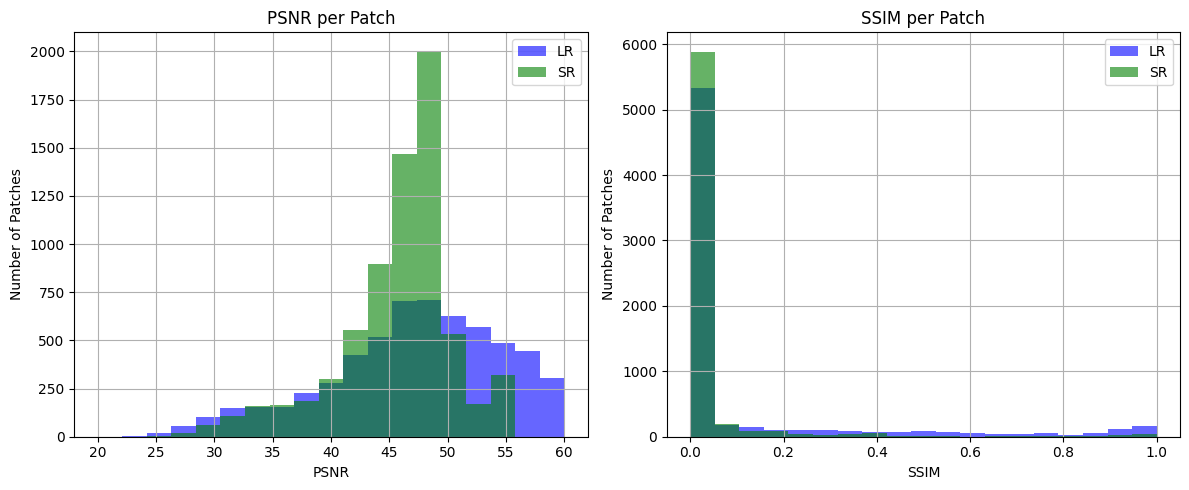


PSNR:
 - SR better in 1637/6936 patches (23.60%)
 - LR better in 5299/6936 patches

SSIM:
 - SR better in 75/6936 patches (1.08%)
 - LR better in 6861/6936 patches

SAM:
 - SR better in 3104/6936 patches (44.75%)
 - LR better in 3832/6936 patches

Average PSNR:
 - SR: 45.66
 - LR: 51.51

Average SSIM:
 - SR: 0.0322
 - LR: 0.1147

Average SAM:
 - SR: 53.79
 - LR: 54.56


In [20]:
if __name__ == '__main__':
    main()